# Evaluation of 3D CNN Model on Duke Dataset

This notebook demonstrates the process of evaluating a 3D Convolutional Neural Network (CNN) model on the Duke dataset. The workflow includes setting up the environment, loading the dataset, preparing the model, making predictions, and calculating various performance metrics. The notebook also visualizes the model's performance using a confusion matrix and ROC curve. 

In [2]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.path.abspath("__file__")), '..')))

### General settings 

This section sets up the general settings and configurations required for the 3D CNN model. It includes importing necessary modules, setting random seeds for reproducibility, and defining important variables such as `JOB_ID`, `PHENOTYPE`, and `WEIGHTS_PATH`. These settings ensure that the environment is correctly configured for the subsequent steps in the workflow.

In [3]:
import random

import numpy as np
import tensorflow as tf

from settings import Settings

settings = Settings()

np.random.seed(settings.RANDOM_SEED)
random.seed(settings.RANDOM_SEED)
tf.random.set_seed(settings.RANDOM_SEED)

JOB_ID = "23187"
JOB_DIR_PATH = os.path.join(settings.BASE_DATA_DIR, "jobs", JOB_ID) 

### Dataset loading 

This section loads the Duke dataset using the `DukeDataset` and `DukeDataGenerator` classes. The dataset is divided into training and testing sets, which are used to train and evaluate the 3D CNN model. The `train_generator` and `test_generator` objects are created to facilitate the loading and preprocessing of the data during training and testing phases.

In [4]:
from datasets import DukeDataGenerator, DukeDataset

dataset = DukeDataset(settings.DATASET_DIR, crop_size=settings.INPUT_SIZE)
test_generator = DukeDataGenerator(
    settings.DATASET_DIR,
    dataset=dataset,
    stage="test",
    dim=settings.INPUT_SIZE,
    batch_size=settings.BATCH_SIZE,
    positive_class=None,
    autoencoder=False,
) 

### Model preparation and evaluation 

This section prepares the 3D CNN model for evaluation by loading the model weights and making predictions on the test dataset. The `evaluate` function is defined to load the model, make predictions, and return the true and predicted labels. 

In [5]:
def predict(PHENOTYPE):
    from tensorflow.keras.models import Model
    
    from models import CNN3D
    
    WEIGHTS_PATH = os.path.join(JOB_DIR_PATH, settings.PHENOTYPES[PHENOTYPE], "checkpoints", "weights.h5") 
    
    test_generator.set_phenotype(PHENOTYPE)    
    input_size = settings.INPUT_SIZE
    model: Model = CNN3D(depth=input_size[0], width=input_size[1], height=input_size[2])
    model.built = True
    model.load_weights(WEIGHTS_PATH) 
    y_true = []
    y_pred = []

    for i in range(len(test_generator)):
        x, y = test_generator[i]
        y_true.extend(y)
        y_pred.extend(model.predict(x).ravel())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    del model 
    return y_true, y_pred 


predictions = {}

for PHENOTYPE in settings.PHENOTYPES:
    y_true, y_pred = predict(PHENOTYPE)
    predictions[PHENOTYPE] = (y_true, y_pred)

2025-03-25 09:26:27.475003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-03-25 09:26:27.475048: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-25 09:26:27.475082: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: frontend
2025-03-25 09:26:27.475091: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: frontend
2025-03-25 09:26:27.475188: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2025-03-25 09:26:27.475247: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.216.1
2025-03-25 09:26:27.475507: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorF

### Evaluating metrics 

This section evaluates the performance metrics of the 3D CNN model for a given phenotype. The `evaluate_all_metrics` function calculates and prints various metrics such as accuracy, precision, recall, AUC, and F1 score. It also generates a confusion matrix to visualize the model's performance. The results provide a comprehensive understanding of the model's effectiveness in classifying the phenotype.

In [6]:
def evaluate_all_metrics(PHENOTYPE, y_true, y_pred):
    from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    roc_auc = roc_auc_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred > 0.5)
    precision = precision_score(y_true, y_pred > 0.5)
    recall = recall_score(y_true, y_pred > 0.5)
    f1 = f1_score(y_true, y_pred > 0.5)
    conf_matrix = confusion_matrix(y_true, y_pred > 0.5)

    metrics = {
        "Phenotype": settings.PHENOTYPES[PHENOTYPE],
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "AUC": roc_auc,
        "F1 Score": f1,
        "Confusion Matrix": conf_matrix
    }

    return metrics 

import pandas as pd

metrics_results = {}

for PHENOTYPE in settings.PHENOTYPES:
    y_true, y_pred = predictions[PHENOTYPE]
    metrics = evaluate_all_metrics(PHENOTYPE, y_true, y_pred)
    metrics_results[PHENOTYPE] = metrics
    metrics = metrics_results[PHENOTYPE]
    
    print(f"Phenotype: {metrics['Phenotype']} ({PHENOTYPE})\n")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"AUC: {metrics['AUC']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")

    conf_matrix_df = pd.DataFrame(
        metrics["Confusion Matrix"], index=np.unique(y_true), columns=np.unique(y_true)
    )

    print("\nConfusion Matrix:")
    print(conf_matrix_df, "\n\n") 

Phenotype: Luminal A (0)

Accuracy: 0.8818
Precision: 0.8884
Recall: 0.9471
AUC: 0.9390
F1 Score: 0.9168

Confusion Matrix:
    0    1
0  76   27
1  12  215 


Phenotype: Luminal B (1)

Accuracy: 0.9606
Precision: 0.7568
Recall: 0.8750
AUC: 0.9906
F1 Score: 0.8116

Confusion Matrix:
     0   1
0  289   9
1    4  28 


Phenotype: HER2 Enriched (2)

Accuracy: 0.9818
Precision: 0.7222
Recall: 0.9286
AUC: 0.9975
F1 Score: 0.8125

Confusion Matrix:
     0   1
0  311   5
1    1  13 


Phenotype: Triple Negative (3)

Accuracy: 0.8242
Precision: 0.4949
Recall: 0.8596
AUC: 0.9474
F1 Score: 0.6282

Confusion Matrix:
     0   1
0  223  50
1    8  49 




### ROC Curve

The ROC curve is a graphical representation of the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. It is used to evaluate the performance of a binary classifier. The area under the ROC curve (AUC) provides a single measure of the model's performance across all classification thresholds. 

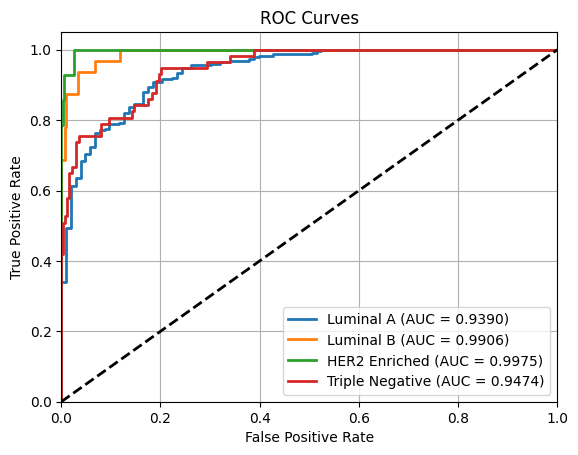

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

%matplotlib inline

plt.figure()

for i, PHENOTYPE in enumerate(settings.PHENOTYPES):
    y_true, y_pred = predictions[PHENOTYPE]
    metrics = metrics_results[PHENOTYPE]
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, lw=2, label=f"{settings.PHENOTYPES[PHENOTYPE]} (AUC = {metrics['AUC']:.4f})")

plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Learning curves

This section plots the learning curves for the 3D CNN model, showing the training and validation AUC and loss over epochs. The learning curves provide insights into the model's performance and help identify potential issues such as overfitting or underfitting.

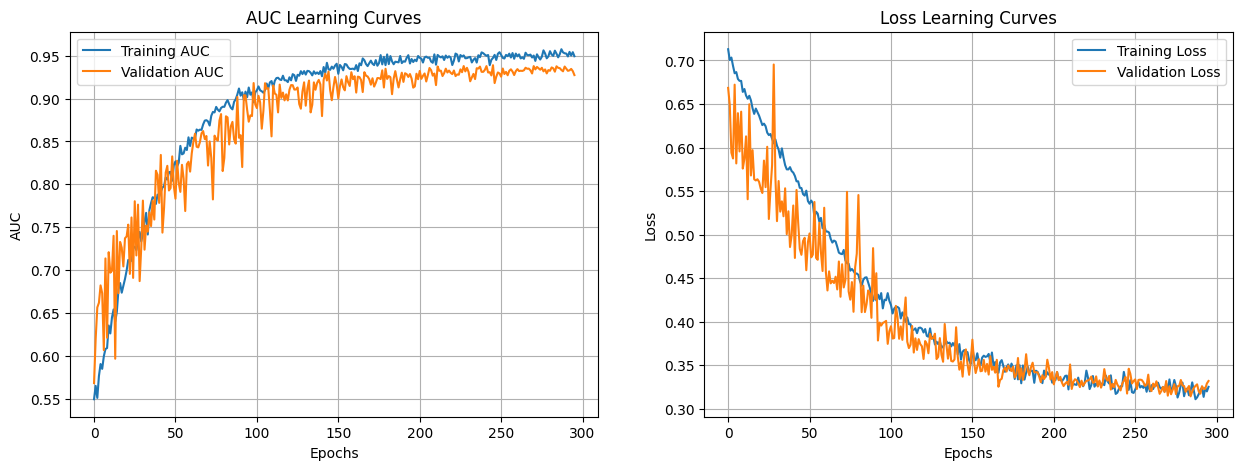

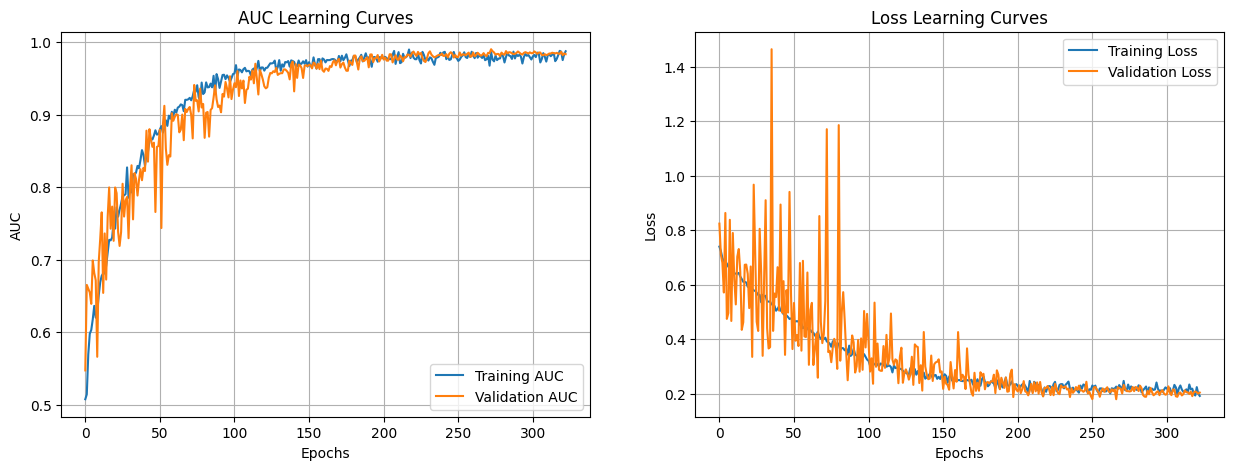

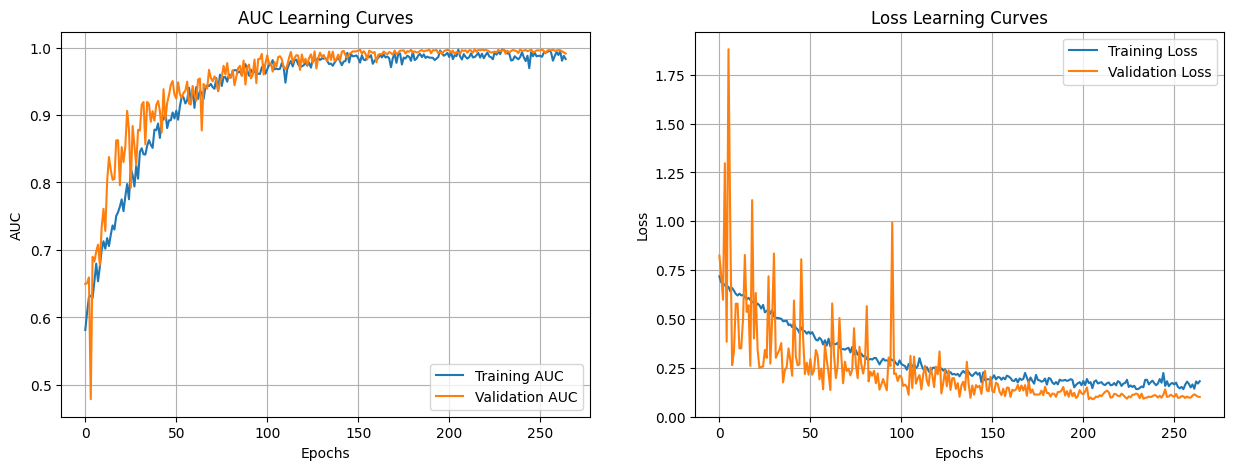

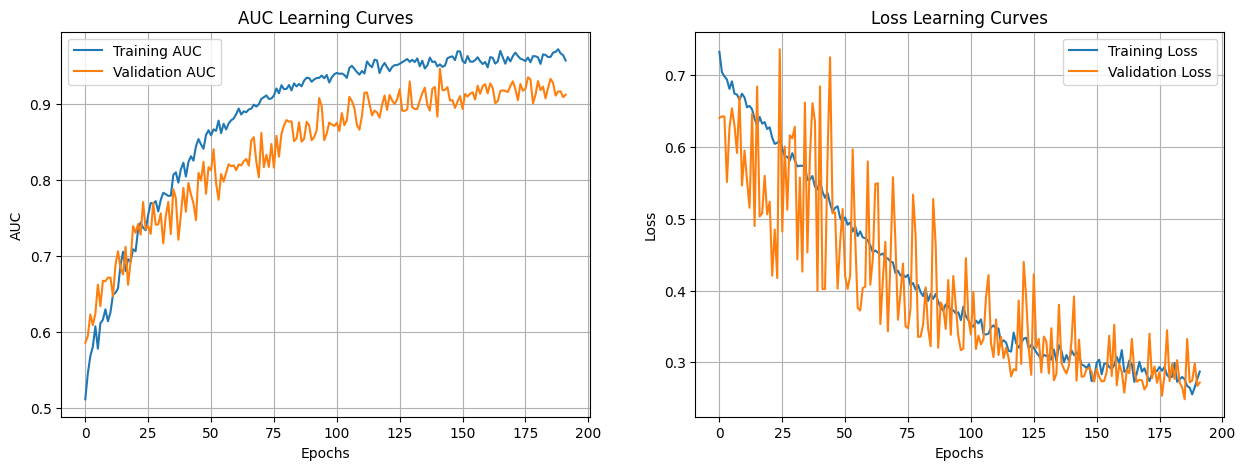

In [36]:
def plot_learning_curves(PHENOTYPE, show=False):
    import os
    import matplotlib.pyplot as plt
    from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

    %matplotlib inline

    # Define the path to the TensorBoard logs
    log_dir_train = os.path.join(JOB_DIR_PATH, settings.PHENOTYPES[PHENOTYPE], "logs", "train")
    log_dir_val = os.path.join(JOB_DIR_PATH, settings.PHENOTYPES[PHENOTYPE], "logs", "validation")

    # Load the TensorBoard logs
    event_acc_train = EventAccumulator(log_dir_train, size_guidance={'tensors': 0})
    event_acc_train.Reload()
    event_acc_val = EventAccumulator(log_dir_val, size_guidance={'tensors': 0})
    event_acc_val.Reload()

    # Extract the data for epoch_auc, epoch_val_auc, epoch_loss, and epoch_val_loss
    epoch_auc_train = event_acc_train.Tensors('epoch_auc')
    epoch_auc_val = event_acc_val.Tensors('epoch_auc')
    epoch_loss_train = event_acc_train.Tensors('epoch_loss')
    epoch_loss_val = event_acc_val.Tensors('epoch_loss')

    # Extract the steps and values
    steps_train = [x.step for x in epoch_auc_train]
    auc_values_train = [tf.make_ndarray(x.tensor_proto).item() for x in epoch_auc_train]
    auc_values_val = [tf.make_ndarray(x.tensor_proto).item() for x in epoch_auc_val]
    loss_values_train = [tf.make_ndarray(x.tensor_proto).item() for x in epoch_loss_train]
    loss_values_val = [tf.make_ndarray(x.tensor_proto).item() for x in epoch_loss_val]

    # Plot the learning curves for AUC
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(steps_train, auc_values_train, label='Training AUC')
    plt.plot(steps_train, auc_values_val, label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.title('AUC Learning Curves')
    plt.legend()
    plt.grid(True)

    # Plot the learning curves for Loss
    plt.subplot(1, 2, 2)
    plt.plot(steps_train, loss_values_train, label='Training Loss')
    plt.plot(steps_train, loss_values_val, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Learning Curves')
    plt.legend()
    plt.grid(True)
    
    if show:
        plt.show()


for PHENOTYPE in settings.PHENOTYPES:
    plot_learning_curves(PHENOTYPE) 